## The Removal of Transient Objects Using Machine Learning Algorithms:
*Created by: Divya Natekar (dyn2009), NYU CUSP: Summer Guided Research*

### Program Logic:
The program simulates a Terrestrial LiDAR Scanner (TLS) positioned at the four corners of the Jay St-Willoughby St intersection. At each corner, the algorithm identifies a series of 'Transient Objects' such as people and vehicles, by comparing it to the references given to it at the input *(manual-filtering.ply = ideally cleaned program and jw-noise-points.ply = noise)*. The filtering process is repeated through four loops, with each loop concluding as the scanner passes through Corner 1->2->3->4, so that occlusions can be captured from multiple angles, in order to effectively remove the noise.

In this program, the Machine Learning supervised algorithm, K-Nearest Neighbors (KNN), has been used, which is a simple yet effective method that classifies each point based on its similarity to its nearest labeled neighboring points. This allows the model to distinguish between the noise (transient objects) and permanent structures.

KNN was chosen for its ability to work effectively with spatial datasets such as point clouds, where proximity and local density play an important role. The model is easy to train with the given reference datasets, and provides an interpretable result which is robust. Hence, making it a good fit for this project.

In [1]:
# ---------------------------- CONFIG ----------------------------
ORIGINAL_PLY      = "jay-willoughby.ply"
REF_KEEP_PLY      = "manual-filtering.ply"
REF_NOISE_PLY     = "jw-noise-points.ply"

LOOPS             = 4
CORNERS           = 4              # 1..4 clockwise
FOV_DEG           = 95.0           # inward-facing wedge width at each corner
VOXEL_SIZE        = 0.10           # ↑ for speed, ↓ for detail (0.08–0.15 typical)
PLANE_DIST_THRESH = 0.05
RANSAC_N          = 3
NUM_RANSAC_ITERS  = 1000
K_NEIGHBORS       = 16
MATCH_RADIUS      = 0.08           # for labeling from references
TRAIN_SAMPLE_MAX  = 200_000        # cap labeled training points per pass
ROI_FOCUS         = 3.0            # oversample ROI (current corner FOV) vs non-ROI in training
KNN_K             = 7
RANDOM_STATE      = 42

# Final-pass behavior:
ENSURE_FINAL_MATCH = True          # If True, "snap" final pass to manual reference
FINAL_SNAP_RADIUS  = 0.10          # NN radius to align final kept with manual reference

# --------------------------- IMPORTS ----------------------------
import numpy as np, open3d as o3d, math, csv, time
from pathlib import Path
from sklearn.neighbors import NearestNeighbors, KDTree, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(RANDOM_STATE)

# ------------------------- UTIL FUNCTIONS -----------------------
def load_ply(path: str) -> o3d.geometry.PointCloud:
    pcd = o3d.io.read_point_cloud(path)
    if pcd.is_empty():
        raise ValueError(f"Empty or unreadable point cloud: {path}")
    return pcd

def voxel_downsample(pcd, voxel):
    return pcd.voxel_down_sample(voxel_size=voxel) if voxel and voxel > 0 else pcd

def estimate_normals(pcd, k=16):
    pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamKNN(knn=k))
    pcd.normalize_normals()
    return pcd

def segment_dominant_plane(pcd, distance_threshold, ransac_n, num_iterations):
    plane_model, inliers = pcd.segment_plane(
        distance_threshold=distance_threshold,
        ransac_n=ransac_n,
        num_iterations=num_iterations,
    )
    return plane_model, inliers

def local_density_feature(points, k=16):
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(points)
    dists, _ = nn.kneighbors(points)
    mean_d = dists[:, 1:].mean(axis=1)  # skip self distance
    return 1.0 / (mean_d + 1e-9)

def build_features(pcd, ground_plane=None, k=16):
    pts = np.asarray(pcd.points)
    # height above ground plane
    if ground_plane is not None:
        a,b,c,d = ground_plane
        denom = math.sqrt(a*a + b*b + c*c) + 1e-9
        height = (a*pts[:,0] + b*pts[:,1] + c*pts[:,2] + d) / denom
    else:
        height = pts[:,2]
    # normals & vertical cue
    if not pcd.has_normals():
        estimate_normals(pcd, k=k)
    normals = np.asarray(pcd.normals)
    abs_nz = np.abs(normals[:,2])
    # local density
    density = local_density_feature(pts, k=k)
    return np.c_[height, density, abs_nz]  # (N,3)

def inward_fov_mask(pts_xy, corner_idx, bbox, fov_deg=90.0):
    """
    pts_xy: (N,2) array of [x,y]
    corner_idx: 1..4 clockwise
      1: (xmin, ymax)  top-left
      2: (xmax, ymax)  top-right
      3: (xmax, ymin)  bottom-right
      4: (xmin, ymin)  bottom-left
    bbox: (xmin, ymin, xmax, ymax)
    Returns boolean mask of points within the inward-facing FOV wedge.
    """
    xmin, ymin, xmax, ymax = bbox
    cx, cy = 0.5*(xmin+xmax), 0.5*(ymin+ymax)

    if corner_idx == 1:
        sx, sy = xmin, ymax;    look = np.array([cx - sx, cy - sy])
    elif corner_idx == 2:
        sx, sy = xmax, ymax;    look = np.array([cx - sx, cy - sy])
    elif corner_idx == 3:
        sx, sy = xmax, ymin;    look = np.array([cx - sx, cy - sy])
    elif corner_idx == 4:
        sx, sy = xmin, ymin;    look = np.array([cx - sx, cy - sy])
    else:
        raise ValueError("corner_idx must be 1..4")

    look_norm = np.linalg.norm(look) + 1e-12
    look_unit = look / look_norm
    vecs = pts_xy - np.array([sx, sy])[None, :]
    vnorm = np.linalg.norm(vecs, axis=1) + 1e-12
    dots = (vecs * look_unit[None, :]).sum(axis=1) / vnorm   # cos(theta)
    # in front of sensor (positive projection) and within half-FOV
    half_cos = math.cos(math.radians(fov_deg/2.0))
    mask = (dots >= half_cos) & (dots > 0)
    return mask

def label_from_references(pts, keep_tree, noise_tree, radius, kd=None, nd=None):
    """
    Returns labels: -1 unlabeled, 1 keep, 0 noise
    If both match (conflict), use nearest with 5% margin; else unlabeled.
    """
    N = len(pts)
    labels = np.full(N, -1, dtype=np.int8)
    if keep_tree is not None:
        keep_hits = keep_tree.query_radius(pts, r=radius)
    else:
        keep_hits = [np.array([], int)] * N
    if noise_tree is not None:
        noise_hits = noise_tree.query_radius(pts, r=radius)
    else:
        noise_hits = [np.array([], int)] * N

    for i in range(N):
        hk = len(keep_hits[i])  > 0
        hn = len(noise_hits[i]) > 0
        if hk and not hn:
            labels[i] = 1
        elif hn and not hk:
            labels[i] = 0
        elif hk and hn:
            if kd is not None and nd is not None:
                if kd[i] < 0.95 * nd[i]:
                    labels[i] = 1
                elif nd[i] < 0.95 * kd[i]:
                    labels[i] = 0
                # else remain -1 (ambiguous)
    return labels

def roi_weighted_sample(idx_pos, idx_neg, roi_mask, max_total, roi_focus=3.0):
    """
    Sample a balanced training set with preference for ROI points.
    """
    # Split each class into ROI vs non-ROI
    pos_roi  = np.intersect1d(idx_pos, np.where(roi_mask)[0], assume_unique=False)
    pos_non  = np.setdiff1d(idx_pos, pos_roi, assume_unique=False)
    neg_roi  = np.intersect1d(idx_neg, np.where(roi_mask)[0], assume_unique=False)
    neg_non  = np.setdiff1d(idx_neg, neg_roi, assume_unique=False)

    # Target per class (balanced)
    per_class = max_total // 2
    # Aim to take more from ROI (roi_focus:1 split)
    def split_counts(n_roi, n_non, total, focus):
        # portion from ROI = focus/(focus+1)
        roi_target = int(min(n_roi, round(total * focus / (focus + 1.0))))
        non_target = int(min(n_non, total - roi_target))
        # If we couldn't fill from one bucket, top up from the other
        if roi_target + non_target < total:
            extra = total - (roi_target + non_target)
            # try to take extra from whichever has capacity
            extra_roi = min(extra, n_roi - roi_target)
            roi_target += extra_roi
            extra -= extra_roi
            non_target += min(extra, n_non - non_target)
        return roi_target, non_target

    p_roi_t, p_non_t = split_counts(len(pos_roi), len(pos_non), per_class, roi_focus)
    n_roi_t, n_non_t = split_counts(len(neg_roi), len(neg_non), per_class, roi_focus)

    # Sample without replacement
    def choose(arr, k):
        if k <= 0: return np.array([], dtype=int)
        if len(arr) <= k: return arr
        return rng.choice(arr, size=k, replace=False)

    pos_sel = np.concatenate([choose(pos_roi, p_roi_t), choose(pos_non, p_non_t)])
    neg_sel = np.concatenate([choose(neg_roi, n_roi_t), choose(neg_non, n_non_t)])
    return pos_sel, neg_sel

# --------------------------- LOAD DATA -------------------------
t0 = time.time()
pcd0 = load_ply(ORIGINAL_PLY)
print("Loaded original:", pcd0)

# Fix the corners from the ORIGINAL bounding box (so sensor positions are fixed)
pts0 = np.asarray(pcd0.points)
xmin, ymin = pts0[:,0].min(), pts0[:,1].min()
xmax, ymax = pts0[:,0].max(), pts0[:,1].max()
BBOX = (xmin, ymin, xmax, ymax)

# References
ref_keep  = load_ply(REF_KEEP_PLY)
ref_noise = load_ply(REF_NOISE_PLY)
keep_pts  = np.asarray(ref_keep.points)
noise_pts = np.asarray(ref_noise.points)
keep_tree  = KDTree(keep_pts)  if keep_pts.size  else None
noise_tree = KDTree(noise_pts) if noise_pts.size else None
if keep_tree is not None and noise_tree is not None:
    kd, _ = keep_tree.query(pts0,  k=1, return_distance=True); kd = kd.reshape(-1)
    nd, _ = noise_tree.query(pts0, k=1, return_distance=True); nd = nd.reshape(-1)
else:
    kd = nd = None

# ------------------------- GLOBAL PREP -------------------------
# Start from original (optionally voxelised once at the beginning for speed)
pcd_curr = voxel_downsample(pcd0, VOXEL_SIZE)
estimate_normals(pcd_curr, k=K_NEIGHBORS)
plane_model, inliers = segment_dominant_plane(pcd_curr, PLANE_DIST_THRESH, RANSAC_N, NUM_RANSAC_ITERS)
print("Ground plane:", plane_model, "| inliers:", len(inliers))

# -------------------------- ITERATIONS -------------------------
stats = []  # rows: (iter_idx, loop, corner, kept, removed)
iter_idx = 0

for L in range(1, LOOPS+1):
    for C in range(1, CORNERS+1):
        iter_idx += 1
        print(f"\n=== Pass: loop {L}, corner {C} ===")

        # Features on current remaining set
        pts = np.asarray(pcd_curr.points)
        if len(pts) == 0:
            print("No points left; aborting remaining passes.")
            stats.append([iter_idx, L, C, 0, 0])
            continue

        X = build_features(pcd_curr, ground_plane=plane_model, k=K_NEIGHBORS)

        # ROI mask for current corner (use ORIGINAL bbox corners; FOV applies to current points in 2D)
        pts_xy = pts[:, :2]
        roi = inward_fov_mask(pts_xy, C, BBOX, fov_deg=FOV_DEG)

        # Label from references (entire current set, but we'll sample with ROI focus)
        labels = label_from_references(pts, keep_tree, noise_tree, MATCH_RADIUS, kd=kd[:len(pts)] if kd is not None else None, nd=nd[:len(pts)] if nd is not None else None)
        idx_keep  = np.where(labels == 1)[0]
        idx_noise = np.where(labels == 0)[0]
        print(f"Labeled this pass → keep: {len(idx_keep):,} | noise: {len(idx_noise):,} | unlabeled: {int((labels==-1).sum()):,}")

        # Build training set (balanced, ROI-focused)
        sel_pos, sel_neg = roi_weighted_sample(idx_keep, idx_noise, roi_mask=roi, max_total=TRAIN_SAMPLE_MAX, roi_focus=ROI_FOCUS)
        train_idx = np.concatenate([sel_pos, sel_neg])
        if train_idx.size < 10:
            # Fallback: if few labels, try whole labeled set (still capped)
            pool = np.concatenate([idx_keep, idx_noise])
            take = min(len(pool), TRAIN_SAMPLE_MAX)
            train_idx = rng.choice(pool, size=take, replace=False)
        y_train = (labels[train_idx]).astype(int)
        X_train = X[train_idx]
        print("Training size:", len(train_idx), "| class balance keep/noise =", int((y_train==1).sum()), "/", int((y_train==0).sum()))

        # Train & predict
        scaler = StandardScaler().fit(X_train)
        clf    = KNeighborsClassifier(n_neighbors=KNN_K)
        clf.fit(scaler.transform(X_train), y_train)
        y_pred = clf.predict(scaler.transform(X))
        keep_ix = np.where(y_pred == 1)[0]
        rem_ix  = np.where(y_pred == 0)[0]
        print("Predicted → keep:", keep_ix.size, "| remove:", rem_ix.size)

        # Export per-pass outputs
        keep_pcd = pcd_curr.select_by_index(keep_ix)
        rem_pcd  = pcd_curr.select_by_index(rem_ix)
        out_keep = f"remaining_loop{L}_corner{C}.ply"
        out_rem  = f"removed_loop{L}_corner{C}.ply"
        o1 = o3d.io.write_point_cloud(out_keep, keep_pcd)
        o2 = o3d.io.write_point_cloud(out_rem,  rem_pcd)
        if not (o1 and o2):
            raise RuntimeError("Failed to write per-pass outputs.")
        print("Saved:", out_keep, "and", out_rem)

        # Stats & cascade for next pass
        stats.append([iter_idx, L, C, keep_ix.size, rem_ix.size])
        pcd_curr = keep_pcd  # cascade: next pass refines the remaining set

# --------------------- FINAL SNAP -------------------
if ENSURE_FINAL_MATCH:
    print("\nSnapping final pass to manual reference…")
    # Take current remaining and align to manual filter with NN radius
    pts_final = np.asarray(pcd_curr.points)
    if keep_pts.size and pts_final.size:
        manual_tree = KDTree(keep_pts)
        hits = manual_tree.query_radius(pts_final, r=FINAL_SNAP_RADIUS)
        keep_mask = np.array([len(ix) > 0 for ix in hits])
        # Split current remaining into "aligned keep" and "aligned remove"
        snap_keep = pcd_curr.select_by_index(np.where(keep_mask)[0])
        snap_rem  = pcd_curr.select_by_index(np.where(~keep_mask)[0])
        # Overwrite last pass files with snapped versions (same naming convention)
        last_keep = f"remaining_loop{LOOPS}_corner{CORNERS}.ply"
        last_rem  = f"removed_loop{LOOPS}_corner{CORNERS}.ply"
        o3d.io.write_point_cloud(last_keep, snap_keep)
        o3d.io.write_point_cloud(last_rem,  snap_rem)
        print("Snapped & saved final pass to better match manual reference.")
    else:
        print("Skip snapping (no points or empty reference).")

# -------------------------- LOG & PLOT -------------------------
# Write iteration stats CSV
with open("iteration_stats.csv", "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["iteration", "loop", "corner", "kept_count", "removed_count"])
    w.writerows(stats)

# Plot removed counts vs iteration to inspect shape
iters  = [r[0] for r in stats]
removed_counts = [r[4] for r in stats]

plt.figure()
plt.plot(iters, removed_counts, marker="o")
plt.title("Removed points per pass (4 loops × 4 corners)")
plt.xlabel("Pass (iteration)")
plt.ylabel("Removed count")
plt.grid(True, linestyle="--", alpha=0.5)
plt.savefig("removed_counts_over_iterations.png", dpi=150)
plt.close()

print(f"\nDone in {time.time()-t0:.1f}s")
print("Wrote: iteration_stats.csv, removed_counts_over_iterations.png")
print("Final pass outputs:", f"remaining_loop{LOOPS}_corner{CORNERS}.ply", f"removed_loop{LOOPS}_corner{CORNERS}.ply")


Loaded original: PointCloud with 1360985 points.
Ground plane: [ 2.85205759e-03  2.60593108e-03  9.99992537e-01 -3.36273500e+03] | inliers: 62115

=== Pass: loop 1, corner 1 ===
Labeled this pass → keep: 1,111,427 | noise: 163,428 | unlabeled: 47,691
Training size: 200000 | class balance keep/noise = 100000 / 100000
Predicted → keep: 974103 | remove: 348443
Saved: remaining_loop1_corner1.ply and removed_loop1_corner1.ply

=== Pass: loop 1, corner 2 ===
Labeled this pass → keep: 957,057 | noise: 10,925 | unlabeled: 6,121
Training size: 110925 | class balance keep/noise = 100000 / 10925
Predicted → keep: 946779 | remove: 27324
Saved: remaining_loop1_corner2.ply and removed_loop1_corner2.ply

=== Pass: loop 1, corner 3 ===
Labeled this pass → keep: 937,886 | noise: 4,621 | unlabeled: 4,272
Training size: 104621 | class balance keep/noise = 100000 / 4621
Predicted → keep: 938473 | remove: 8306
Saved: remaining_loop1_corner3.ply and removed_loop1_corner3.ply

=== Pass: loop 1, corner 4 ===


#### Generating the graph plots for this program:

,iteration,loop,corner,removed_file,remaining_file,removed_count,remaining_count
0,1,1,1,removed_loop1_corner1.ply,remaining_loop1_corner1.ply,348443,974103
1,2,1,2,removed_loop1_corner2.ply,remaining_loop1_corner2.ply,27324,946779
2,3,1,3,removed_loop1_corner3.ply,remaining_loop1_corner3.ply,8306,938473
3,4,1,4,removed_loop1_corner4.ply,remaining_loop1_corner4.ply,5317,933156
4,5,2,1,removed_loop2_corner1.ply,remaining_loop2_corner1.ply,2627,930529
5,6,2,2,removed_loop2_corner2.ply,remaining_loop2_corner2.ply,2284,928245
6,7,2,3,removed_loop2_corner3.ply,remaining_loop2_corner3.ply,1200,927045
7,8,2,4,removed_loop2_corner4.ply,remaining_loop2_corner4.ply,1006,926039
8,9,3,1,removed_loop3_corner1.ply,remaining_loop3_corner1.ply,713,925326
9,10,3,2,removed_loop3_corner2.ply,remaining_loop3_corner2.ply,619,924707


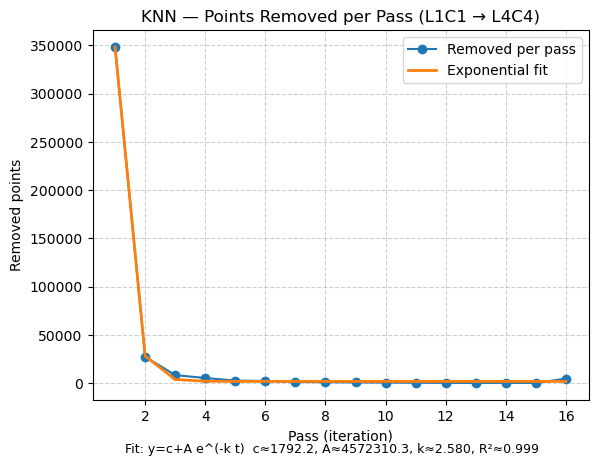

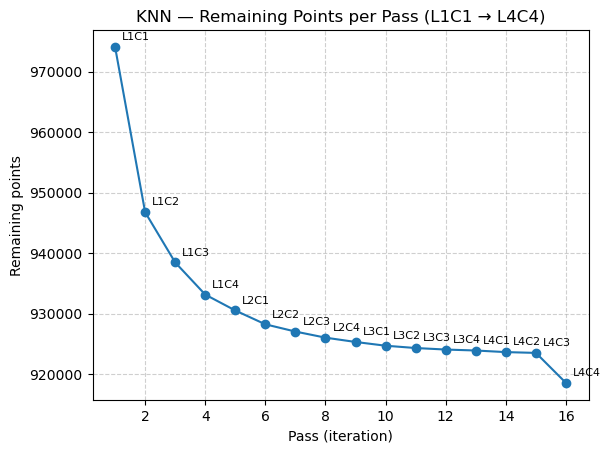

Exponential removal fit → Fit: y=c+A e^(-k t)  c≈1792.2, A≈4572310.3, k≈2.580, R²≈0.999


In [2]:
import re, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import open3d as o3d
from pathlib import Path
from IPython.display import display

# File path
CANDIDATE_DIRS = [Path("."), Path("./outputs"), Path("./removed_outputs"), Path("./corner_outputs_fast")]
rem_pat  = re.compile(r"^removed_loop([1-4])_corner([1-4])\.ply$", re.IGNORECASE)
keep_pat = re.compile(r"^remaining_loop([1-4])_corner([1-4])\.ply$", re.IGNORECASE)

# Discover files
paths = {}
for d in CANDIDATE_DIRS:
    if not d.exists(): continue
    for fn in os.listdir(d):
        m = rem_pat.match(fn)
        if m:
            L, C = int(m.group(1)), int(m.group(2))
            paths[("removed", L, C)] = d / fn
        m = keep_pat.match(fn)
        if m:
            L, C = int(m.group(1)), int(m.group(2))
            paths[("remaining", L, C)] = d / fn

if not paths:
    raise SystemExit("No pass files found. Ensure files are named like removed_loop1_corner1.ply / remaining_loop1_corner1.ply")

def count_points(pth: Path) -> int:
    pcd = o3d.io.read_point_cloud(str(pth))
    return np.asarray(pcd.points).shape[0]

# Building L1C1→L4C4 table
rows, missing = [], []
for L in range(1, 5):
    for C in range(1, 5):
        rem_p = paths.get(("removed", L, C))
        keep_p = paths.get(("remaining", L, C))
        rem_n = count_points(rem_p) if rem_p and rem_p.exists() else None
        keep_n = count_points(keep_p) if keep_p and keep_p.exists() else None
        if rem_n is None or keep_n is None:
            missing.append((L, C, bool(rem_p), bool(keep_p)))
        rows.append({
            "iteration": 4*(L-1)+C,
            "loop": L,
            "corner": C,
            "removed_file": str(rem_p) if rem_p else "",
            "remaining_file": str(keep_p) if keep_p else "",
            "removed_count": rem_n if rem_n is not None else 0,
            "remaining_count": keep_n if keep_n is not None else 0
        })

df = pd.DataFrame(rows).sort_values(["loop","corner"]).reset_index(drop=True)
display(df)
if missing:
    print("⚠️ Missing passes (loop, corner, has_removed, has_remaining):", missing)

# Preparing arrays
iters   = df["iteration"].to_numpy(dtype=float)
removed = df["removed_count"].to_numpy(dtype=float)
remain  = df["remaining_count"].to_numpy(dtype=float)

# Helper: R^2
def r2_score(y_true, y_pred):
    ss_res = float(np.sum((y_true - y_pred)**2))
    ss_tot = float(np.sum((y_true - np.mean(y_true))**2))
    return 1.0 - ss_res/ss_tot if ss_tot > 0 else 0.0

# Try exponential fit y = c + A e^{-k t} on removed
yhat, fit_text = None, None
try:
    from scipy.optimize import curve_fit
    def exp_decay(t, c, A, k): return c + A*np.exp(-k*t)
    p0 = [removed.min(), max(1.0, removed.max()-removed.min()), 0.3]
    popt, _ = curve_fit(exp_decay, iters, removed, p0=p0, maxfev=20000)
    c_hat, A_hat, k_hat = popt
    yhat = exp_decay(iters, *popt)
    R2 = r2_score(removed, yhat)
    fit_text = f"Fit: y=c+A e^(-k t)  c≈{c_hat:.1f}, A≈{A_hat:.1f}, k≈{k_hat:.3f}, R²≈{R2:.3f}"
except Exception:
    # Fallback: c≈0, fit log-linear
    mpos = removed > 0
    if mpos.sum() >= 2:
        t = iters[mpos]; y = removed[mpos]
        X = np.c_[np.ones_like(t), -t]
        beta, *_ = np.linalg.lstsq(X, np.log(y), rcond=None)
        logA, k_hat = beta[0], beta[1]
        A_hat = float(np.exp(logA))
        yhat = A_hat*np.exp(-k_hat*iters)
        R2 = r2_score(removed, yhat)
        fit_text = f"Fit: y=A e^(-k t)  A≈{A_hat:.1f}, k≈{k_hat:.3f}, R²≈{R2:.3f}"

# Plot: removed per pass 
plt.figure()
plt.plot(iters, removed, marker="o", label="Removed per pass")
if yhat is not None:
    plt.plot(iters, yhat, linewidth=2, label="Exponential fit")
plt.title("KNN — Points Removed per Pass (L1C1 → L4C4)")
plt.xlabel("Pass (iteration)")
plt.ylabel("Removed points")
plt.grid(True, linestyle="--", alpha=0.6)
if yhat is not None:
    plt.suptitle(fit_text, y=0.02, fontsize=9)
plt.legend()
plt.show()

# Plot: remaining per pass (shows if L4C4 is slightly higher)
plt.figure()
plt.plot(iters, remain, marker="o")
plt.title("KNN — Remaining Points per Pass (L1C1 → L4C4)")
plt.xlabel("Pass (iteration)")
plt.ylabel("Remaining points")
plt.grid(True, linestyle="--", alpha=0.6)
# Optional annotate LxCy on points
for i, (L, C, x, y) in enumerate(zip(df["loop"], df["corner"], iters, remain)):
    plt.annotate(f"L{L}C{C}", (x, y), textcoords="offset points", xytext=(5,5), fontsize=8)
plt.show()

# Quick textual note for your report
if yhat is not None:
    print(f"Exponential removal fit → {fit_text}")
else:
    print("Exponential fit not produced (insufficient data or SciPy missing).")
